In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dk
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# file_path = "Processed_Data/Mapped_Dataset.csv"
# file_path="C:/Users/hoang/FileCSV_DACN_2025/Benign_ddos_dos_Mapped_Dataset.csv"
file_path = "/mnt/c/Users/hoang/FileCSV_DACN_2025/2Type_BenDoS_Mapped_Dataset.csv"

df = dk.read_csv(file_path)

2025-04-13 14:08:08.363939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744553288.504954   86927 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744553288.545843   86927 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744553288.864336   86927 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744553288.864371   86927 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744553288.864373   86927 computation_placer.cc:177] computation placer alr

label
1    42075298
0     1098195
Name: count, dtype: int64


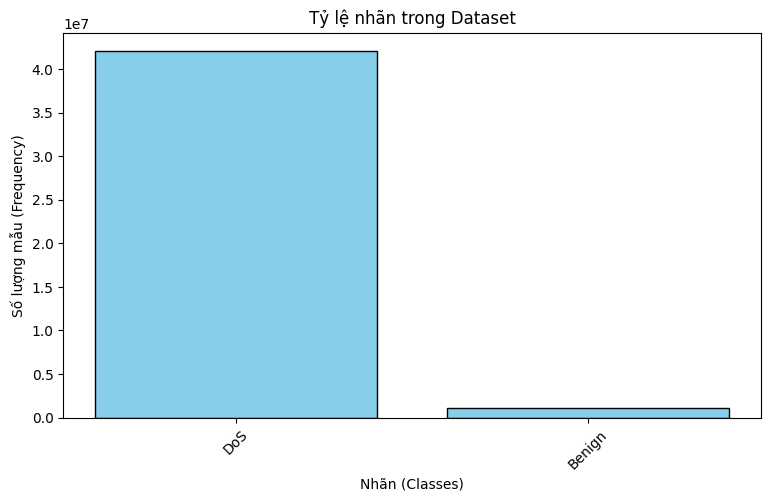

In [2]:
import matplotlib.pyplot as plt

# labels = ['BenignTraffic', 'DDoS-ICMP_Flood', 'DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-SYN_Flood', 
#                    'DDoS-SynonymousIP_Flood', 'DDoS-TCP_Flood', 'DDoS-UDP_Flood', 'DoS-SYN_Flood', 'DoS-TCP_Flood', 'DoS-UDP_Flood']
# Đếm số lượng mỗi nhãn
label_counts = df['label'].value_counts().compute()
print(label_counts)
labels = ["DoS", "Benign"]
# Vẽ biểu đồ cột
plt.figure(figsize=(9, 5))
plt.bar(labels, label_counts.values, color='skyblue', edgecolor='black')
plt.xlabel("Nhãn (Classes)")
plt.ylabel("Số lượng mẫu (Frequency)")
plt.title("Tỷ lệ nhãn trong Dataset")
plt.xticks(range(len(labels)) ,labels, rotation =45)
plt.show()

In [3]:
#Global var 
batch_size = 512
ratio_test_all = 0.15

from dask_ml.model_selection import train_test_split 
# chia train test ratio 0.8:0.2 & random 
train_df, test_df = train_test_split(df, test_size=ratio_test_all, random_state=42)

# # load từng batch
def dask_to_tf_dataset(dask_df, batch_size): 
    def generator():
        for batch in dask_df.to_delayed():
            batch = batch.compute()  
            if batch.empty:
                continue

            X = batch.drop(columns='label').values.astype(np.float32)
            y = batch['label'].values.astype(np.int32)  # nhị phân: 0 hoặc 1

            num_splits = max(1, len(X) // batch_size)
            X_batches = np.array_split(X, num_splits)
            y_batches = np.array_split(y, num_splits)

            for X_batch, y_batch in zip(X_batches, y_batches):
                yield X_batch, y_batch

    output_signature = ( 
        tf.TensorSpec(shape=(None, 46), dtype=tf.float32), 
        tf.TensorSpec(shape=(None,), dtype=tf.int32),  # không phải one-hot nữa
    )
    
    return tf.data.Dataset.from_generator(generator, output_signature=output_signature).prefetch(tf.data.AUTOTUNE)

/home/hoangvn/miniconda3/miniconda3/envs/doan/lib/python3.9/site-packages/dask_ml/model_selection/_split.py:464: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(


In [4]:
train_gen = dask_to_tf_dataset(train_df, 512).repeat()
test_gen = dask_to_tf_dataset(test_df, 512)

I0000 00:00:1744553362.420769   86927 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:02:00.0, compute capability: 7.5


In [22]:
from datetime import datetime, timedelta
# shape
features, labels = next(iter(train_gen))
input_shape = (features.shape[1], 1)
# output_shape = labels.shape[1]

print(f"Input Shape: {input_shape}")

from tensorflow import keras
# Định nghĩa mô hình CNN
# VGG, ...
# Conv2D, tabular, ...
# HE, tính tương thích của HE với CNN
# Tính chất data in, out; Học tăng cường
start_time = datetime.now()

model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"),
    layers.MaxPooling1D(pool_size=4),
    layers.Conv1D(filters=64, kernel_size=3,  padding="same",activation="relu"),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')  # dùng sigmoid thay cho softmax
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# for batch in dataloader:
#     X_batch = batch[:, :-1]
#     y_batch = batch[:, -1]
#     y_onehot = to_categorical(y_batch, num_classes=10)
    
#     model.train_on_batch(X_batch, y_onehot, verbose=1)
from tensorflow.keras.callbacks import CSVLogger

csv_logger = CSVLogger("log_mono/"+ datetime.now().strftime("%Hh%Mp__%d-%m-%Y")+".csv" , append=True)
model.fit(train_gen, epochs=25, steps_per_epoch=70000, verbose = 1, callbacks=[csv_logger])


end_time = datetime.now()
simulated_time = end_time - start_time

# Lưu mô hình
model.save("saved_model/cnn_model_2-0_batch512_" + datetime.now().strftime("%Hh%Mp__%d-%m-%Y")+".keras")

print(f"Simulated time: {simulated_time}")

Input Shape: (46, 1)
Epoch 1/25


I0000 00:00:1744526561.462736    7896 service.cc:152] XLA service 0x7f38f400bab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744526561.462825    7896 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 with Max-Q Design, Compute Capability 7.5
2025-04-13 06:42:41.536791: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744526561.835424    7896 cuda_dnn.cc:529] Loaded cuDNN version 90300


   30/70000 ━━━━━━━━━━━━━━━━━━━━ 6:18 5ms/step - accuracy: 0.5723 - loss: 0.7350

2025-04-13 06:42:46.097273: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 168 bytes spill stores, 168 bytes spill loads

I0000 00:00:1744526566.114696    7896 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  363/70000 ━━━━━━━━━━━━━━━━━━━━ 14:11 12ms/step - accuracy: 0.8745 - loss: 0.3237

2025-04-13 06:42:50.521993: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 96 bytes spill stores, 96 bytes spill loads



  772/70000 ━━━━━━━━━━━━━━━━━━━━ 19:06 17ms/step - accuracy: 0.9228 - loss: 0.2168

2025-04-13 06:42:58.714571: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 88 bytes spill stores, 88 bytes spill loads



70000/70000 ━━━━━━━━━━━━━━━━━━━━ 529s 7ms/step - accuracy: 0.9917 - loss: 0.0377
Epoch 2/25
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 497s 7ms/step - accuracy: 0.9954 - loss: 0.0219
Epoch 3/25
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 498s 7ms/step - accuracy: 0.9966 - loss: 0.0163
Epoch 4/25
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 489s 7ms/step - accuracy: 0.9990 - loss: 0.0060
Epoch 5/25
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 496s 7ms/step - accuracy: 0.9961 - loss: 0.0170
Epoch 6/25
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 495s 7ms/step - accuracy: 0.9946 - loss: 0.0259
Epoch 7/25
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 495s 7ms/step - accuracy: 0.9947 - loss: 0.0248
Epoch 8/25
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 493s 7ms/step - accuracy: 0.9949 - loss: 0.0229
Epoch 9/25
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 500s 7ms/step - accuracy: 0.9949 - loss: 0.0242
Epoch 10/25
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 516s 7ms/step - accuracy: 0.9920 - loss: 0.0414
Epoch 11/25
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 500s 7ms/step - accuracy: 0.9931 - loss: 0.03

In [7]:
from tensorflow.keras.models import load_model
input_model = "/home/hoangvn/Enhancing_PP_of_FL_for_IDS/saved_model/cnn_model_2-0_batch512_10h07p__13-04-2025.keras"
model = load_model(input_model)

output = model.evaluate(test_gen, steps = 12350)
print(f'Loss: {output[0]} Acc: {output[1]}')

I0000 00:00:1744551959.734598   82761 service.cc:152] XLA service 0x7f3144005530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744551959.734678   82761 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 with Max-Q Design, Compute Capability 7.5
2025-04-13 13:45:59.770966: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744551959.870311   82761 cuda_dnn.cc:529] Loaded cuDNN version 90300


   49/12350 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.9919 - loss: 0.0306 

I0000 00:00:1744551960.797223   82761 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12350/12350 ━━━━━━━━━━━━━━━━━━━━ 304s 24ms/step - accuracy: 0.9901 - loss: 0.0383
Loss: 0.03855675086379051 Acc: 0.9900259971618652


Batch test:  12642


I0000 00:00:1744553807.968330   87349 service.cc:152] XLA service 0x7f6598004920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744553807.968375   87349 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 with Max-Q Design, Compute Capability 7.5
2025-04-13 14:16:47.996115: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744553808.068231   87349 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744553808.965564   87349 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-04-13 14:44:53.325949: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Precision:  0.9899625280270642
Recall:  0.9999020183117945
F1-Score:  0.9949074490005426


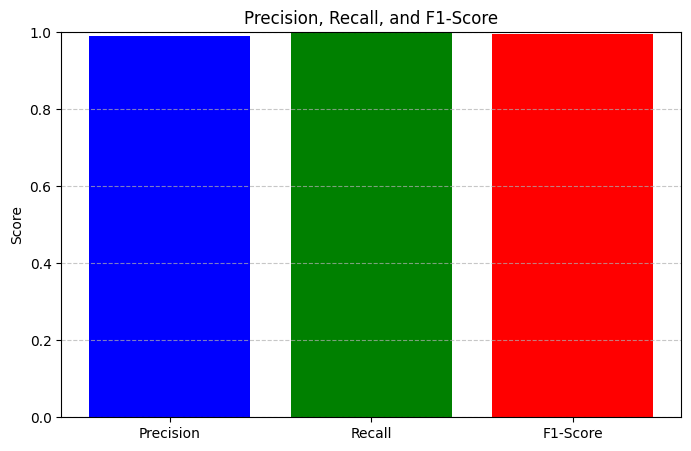

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

input_model = "/home/hoangvn/Enhancing_PP_of_FL_for_IDS/saved_model/cnn_model_2-0_batch512_10h07p__13-04-2025.keras"
model = load_model(input_model)

# Tính số hàng thật sự trong test_df
num_samples_test = test_df.shape[0].compute()
# Tính số batch
num_batches_test = int(np.ceil(num_samples_test / batch_size))
print("Batch test: ", num_batches_test)

y_true_all = []
y_pred_all = []

for X_batch, y_batch in test_gen.take(num_batches_test):
    y_true_all.extend(y_batch.numpy().flatten())

    y_pred_prob = model.predict(X_batch, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    y_pred_all.extend(y_pred)

# Tính metric
precision = precision_score(y_true_all, y_pred_all, average='binary')
recall = recall_score(y_true_all, y_pred_all, average='binary')
f1 = f1_score(y_true_all, y_pred_all, average='binary')

print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1)

param_names = ['Precision', 'Recall', 'F1-Score']
array = [precision, recall, f1]

x = np.arange(len(param_names))
width = 0.2  # Độ rộng của mỗi cột
plt.figure(figsize=(8, 5))
plt.bar(param_names, array, color=['blue', 'green', 'red'])

# Cấu hình trục và nhãn
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score")
plt.ylim(0, 1)  # Giá trị từ 0 đến 1
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Hiển thị biểu đồ
plt.show()


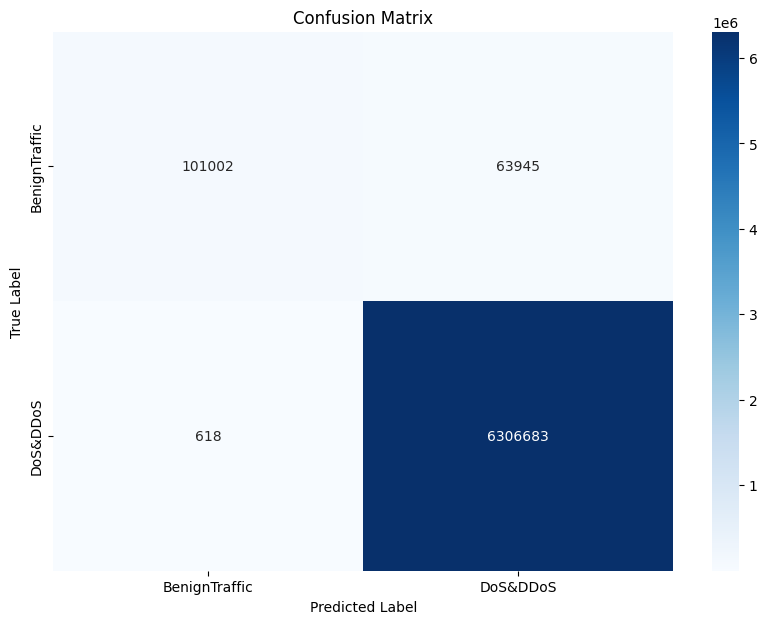

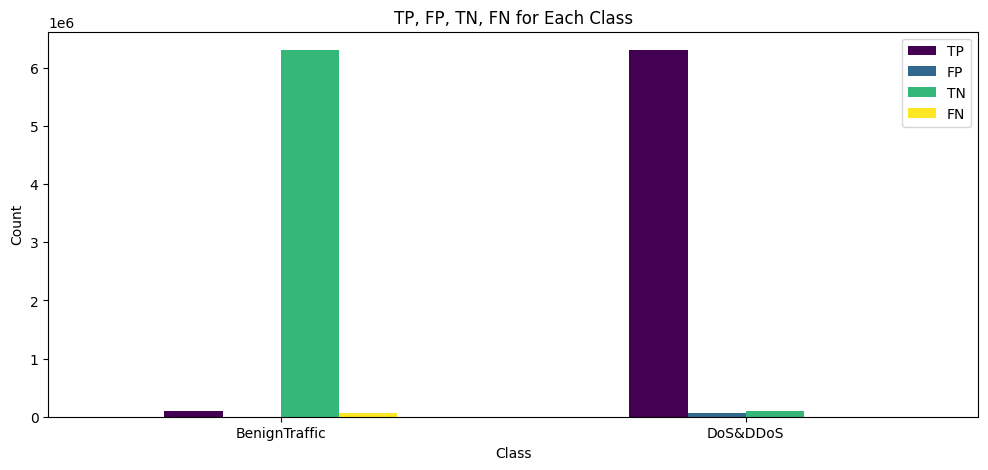

: 

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_true_all, y_pred_all)

attack_types =['BenignTraffic', 'DoS&DDoS']
# Vẽ heatmap
plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)

# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Hiển thị
plt.show()


metrics = []
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])
# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(12, 5), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class")
plt.xticks(rotation=0)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()